In [114]:
# this session is for data expoloration and feature selection. 

In [9]:
%matplotlib inline  
import pandas as pd
from datetime import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt, pi
import seaborn as sns
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from collections import Counter

plt.rcParams['figure.figsize'] = [16, 10]


In [10]:
43178/3600

11.99388888888889

In [11]:
# load the data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

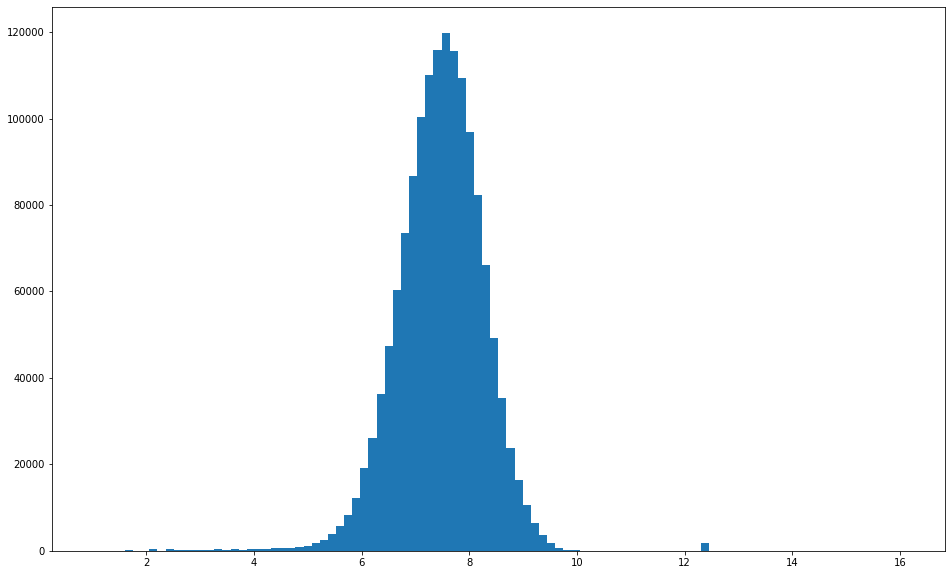

In [12]:
plt.figure()
plt.hist(np.log(train_data['trip_duration'])+1, bins=100)
plt.show()

In [19]:
# get rid off the data 3 standard deviation away
train_data['log_duration'] = np.log(train_data['trip_duration'].values + 1)
logMean = np.mean(train_data['log_duration'])
logSTD = np.std(train_data['log_duration'])
train_data = train_data[train_data['log_duration']<logMean+3*logSTD]
train_data = train_data[train_data['log_duration']>logMean-3*logSTD]

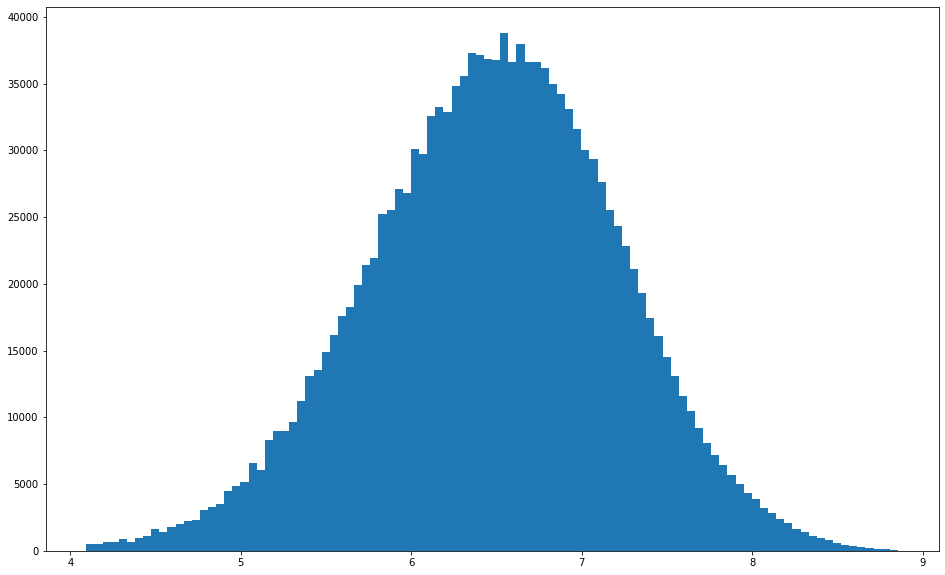

In [21]:
plt.figure()
plt.hist(train_data['log_duration'], bins=100)
plt.show()

In [4]:
train_data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [5]:
# min time of the trip is 1min and max is 3.526282e+06???
# one second of trip won't get you anywhere, need to deal with outliers

In [6]:
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


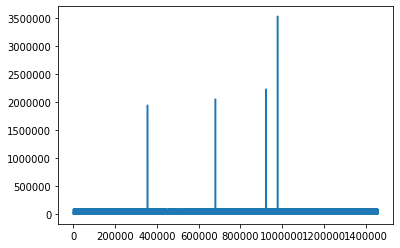

In [8]:
# try to clean up the outlier case
plt.figure()
plt.plot(train_data.trip_duration)

In [122]:
# get rid off the data that are two standard deviation away
# assign mean value to the outliers
mean = 959.4
std = 5237.4
train_data.loc[(train_data.trip_duration>mean+3*std) | (train_data.trip_duration>mean+3*std), 'trip_duration'] = 959

# try to clean up the outlier case

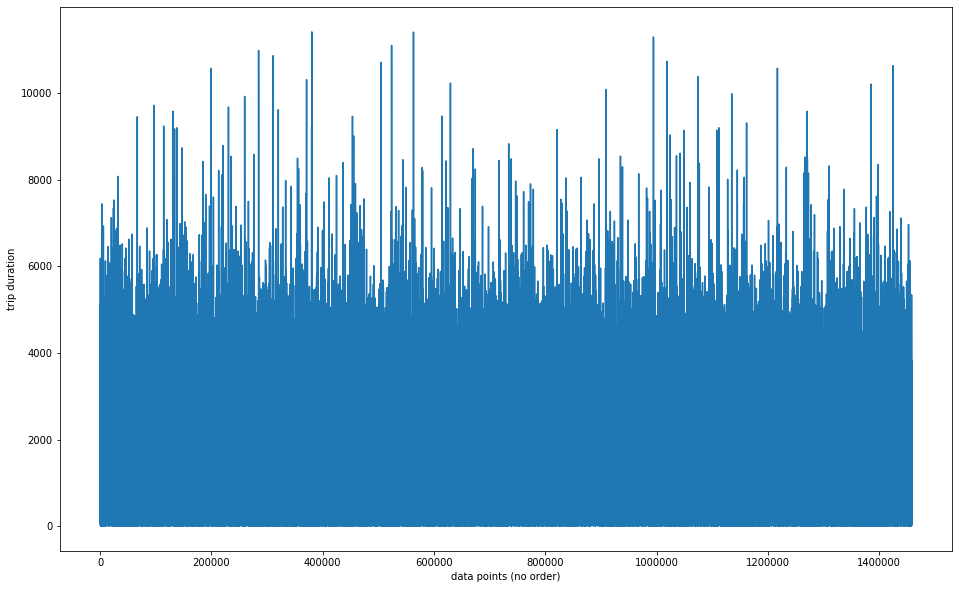

In [157]:
# visualize the outlier case after this
figure = plt.figure()
plt.plot(train_data.trip_duration)
plt.xlabel('data points (no order)')
plt.ylabel('trip duration')
plt.show()

In [124]:
train_data

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373


In [125]:
# sampling rate: 1/5
drop_data_index = [i for i in range(1458644) if i%5!=0]
train_data = train_data.drop(drop_data_index)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443
10,id1436371,2,2016-05-10 22:08:41,2016-05-10 22:29:55,1,-73.982651,40.763840,-74.002228,40.732990,N,1274
15,id3319787,1,2016-05-16 15:29:02,2016-05-16 15:32:33,1,-73.955513,40.768593,-73.948761,40.771545,N,211
20,id2070428,1,2016-02-28 02:23:02,2016-02-28 02:31:08,1,-73.980370,40.742420,-73.962852,40.760635,N,486
...,...,...,...,...,...,...,...,...,...,...,...
1458620,id0694577,2,2016-04-28 20:51:03,2016-04-28 21:10:25,1,-73.966324,40.758072,-74.006516,40.736641,N,1162
1458625,id3730733,2,2016-01-25 17:21:15,2016-01-25 17:54:37,1,-73.989655,40.740612,-73.961029,40.765366,N,2002
1458630,id0287353,2,2016-06-25 03:44:32,2016-06-25 03:53:41,5,-73.991508,40.727135,-73.988136,40.740932,N,549
1458635,id3027038,2,2016-05-19 14:46:55,2016-05-19 14:50:52,1,-73.985390,40.763020,-73.989708,40.767502,N,237


In [126]:
train_data.reset_index().drop('index',axis = 1)
train_data

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373


In [127]:
# attention: this action will reduce the size of the framework, index is changed，there will be mi
#missing index
# clean the location data. get rid of data points that fall outside NYC
train_data = train_data[train_data['pickup_longitude'] <= -73.75]
train_data = train_data[train_data['pickup_longitude'] >= -74.03]
train_data = train_data[train_data['pickup_latitude'] <= 40.85]
train_data = train_data[train_data['pickup_latitude'] >= 40.63]
train_data = train_data[train_data['dropoff_longitude'] <= -73.75]
train_data = train_data[train_data['dropoff_longitude'] >= -74.03]
train_data = train_data[train_data['dropoff_latitude'] <= 40.85]
train_data = train_data[train_data['dropoff_latitude'] >= 40.63]

In [128]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1439183 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1439183 non-null object
vendor_id             1439183 non-null int64
pickup_datetime       1439183 non-null object
dropoff_datetime      1439183 non-null object
passenger_count       1439183 non-null int64
pickup_longitude      1439183 non-null float64
pickup_latitude       1439183 non-null float64
dropoff_longitude     1439183 non-null float64
dropoff_latitude      1439183 non-null float64
store_and_fwd_flag    1439183 non-null object
trip_duration         1439183 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 131.8+ MB


In [170]:
city_lat_border

(40.63, 40.85)

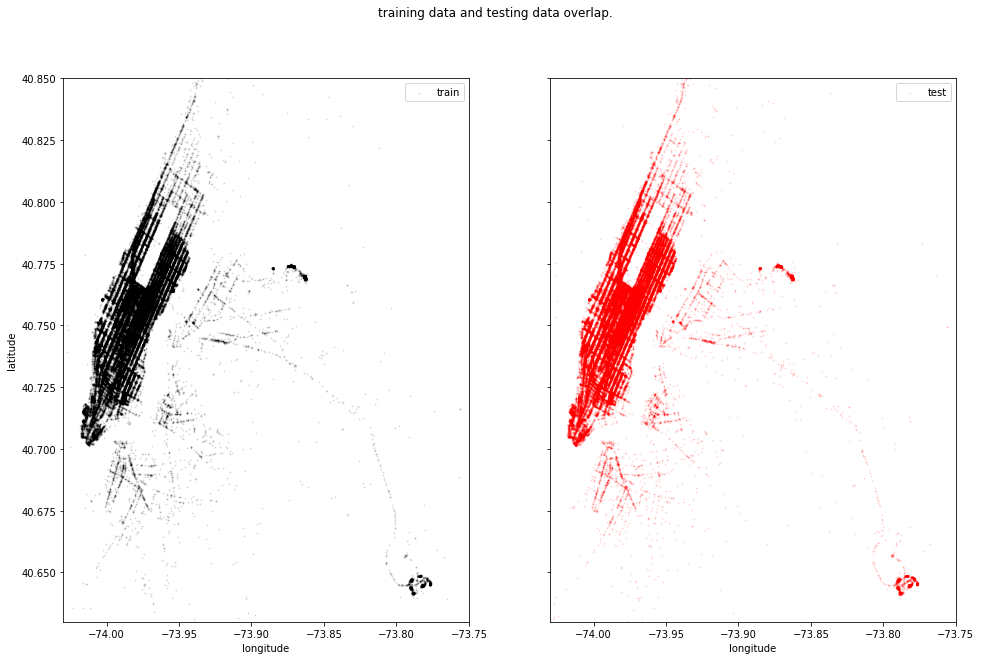

In [154]:

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train_data['pickup_longitude'].values[:100000], train_data['pickup_latitude'].values[:100000],
              color='black', s=1, label='train', alpha=0.1)
ax[1].scatter(test_data['pickup_longitude'].values[:100000], test_data['pickup_latitude'].values[:100000],
              color='red', s=1,label='test', alpha=0.1)
fig.suptitle('training data and testing data overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In [129]:
# we can see there is missing index (not 0,1,2,3... can be 0,1,4,5....)
train_data.index

Int64Index([      0,       1,       2,       3,       4,       5,       6,
                  7,       8,       9,
            ...
            1458634, 1458635, 1458636, 1458637, 1458638, 1458639, 1458640,
            1458641, 1458642, 1458643],
           dtype='int64', length=1439183)

No handles with labels found to put in legend.


Text(0, 0.5, 'Time in Seconds')

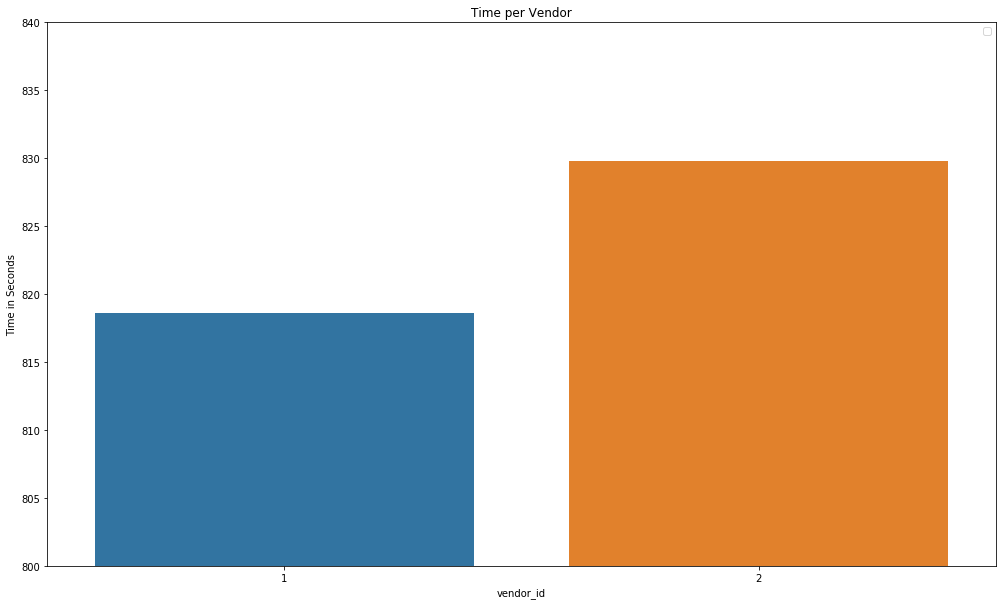

In [149]:
import warnings
warnings.filterwarnings("ignore")
plot_vendor = train_data.groupby('vendor_id')['trip_duration'].mean()
plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=800)
plt.ylim(ymax=840)
sns.barplot(plot_vendor.index,plot_vendor.values)
plt.title('Time per Vendor')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')

No handles with labels found to put in legend.


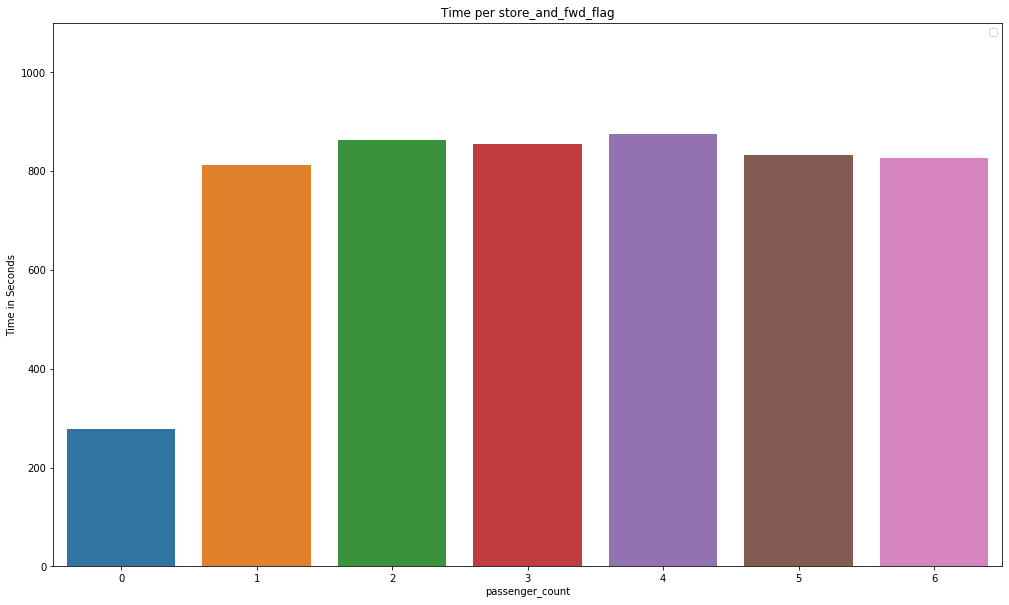

In [151]:
pc = train_data.groupby('passenger_count')['trip_duration'].mean()

plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
plt.title('Time per store_and_fwd_flag')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')
sns.barplot(pc.index,pc.values)

# time stamp clean up: make sure the time is in the datetime format
# make sure the date format is correct.

In [130]:
train_data.pickup_datetime # notice the dtype is object

0          2016-03-14 17:24:55
1          2016-06-12 00:43:35
2          2016-01-19 11:35:24
3          2016-04-06 19:32:31
4          2016-03-26 13:30:55
                  ...         
1458639    2016-04-08 13:31:04
1458640    2016-01-10 07:35:15
1458641    2016-04-22 06:57:41
1458642    2016-01-05 15:56:26
1458643    2016-04-05 14:44:25
Name: pickup_datetime, Length: 1439183, dtype: object

In [131]:
train_data.pickup_datetime = pd.to_datetime(train_data.pickup_datetime) # replace the column with new column

In [132]:
train_data.pickup_datetime 

0         2016-03-14 17:24:55
1         2016-06-12 00:43:35
2         2016-01-19 11:35:24
3         2016-04-06 19:32:31
4         2016-03-26 13:30:55
                  ...        
1458639   2016-04-08 13:31:04
1458640   2016-01-10 07:35:15
1458641   2016-04-22 06:57:41
1458642   2016-01-05 15:56:26
1458643   2016-04-05 14:44:25
Name: pickup_datetime, Length: 1439183, dtype: datetime64[ns]

In [133]:
test_data['pickup_datetime'] = pd.to_datetime(test_data.pickup_datetime)


In [134]:
train_data.loc[:,'pickup_date'] = train_data['pickup_datetime'].dt.date
test_data.loc[:,'pickup_date'] = test_data['pickup_datetime'].dt.date
train_data['dropoff_datetime'] = pd.to_datetime(train_data.dropoff_datetime)
train_data.head()


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26


In [135]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1439183 entries, 0 to 1458643
Data columns (total 12 columns):
id                    1439183 non-null object
vendor_id             1439183 non-null int64
pickup_datetime       1439183 non-null datetime64[ns]
dropoff_datetime      1439183 non-null datetime64[ns]
passenger_count       1439183 non-null int64
pickup_longitude      1439183 non-null float64
pickup_latitude       1439183 non-null float64
dropoff_longitude     1439183 non-null float64
dropoff_latitude      1439183 non-null float64
store_and_fwd_flag    1439183 non-null object
trip_duration         1439183 non-null int64
pickup_date           1439183 non-null object
dtypes: datetime64[ns](2), float64(4), int64(3), object(3)
memory usage: 142.7+ MB


In [136]:
# this step is for data visualization and analysis:
# trip duration and vendor ID
# trip duration and passenger count
# trip duration and store_and_fwd_flag

train_data.passenger_count

0          1
1          1
2          1
3          1
4          1
          ..
1458639    4
1458640    1
1458641    1
1458642    1
1458643    1
Name: passenger_count, Length: 1439183, dtype: int64

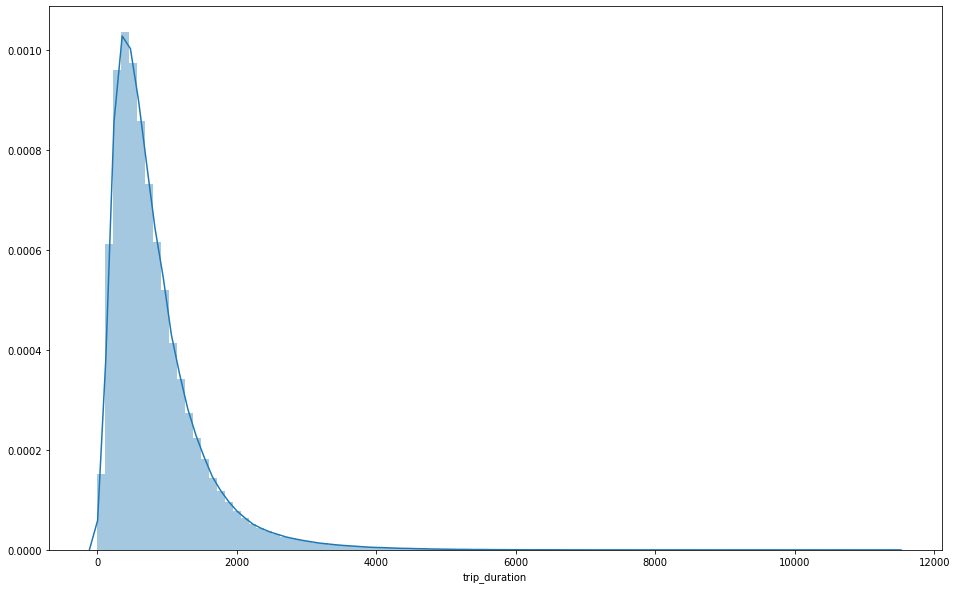

In [153]:
# understand the distribution of the prediction target
#plt.hist(train_data.trip_duration, bins=100)
sns.distplot(train_data.trip_duration, bins =100)


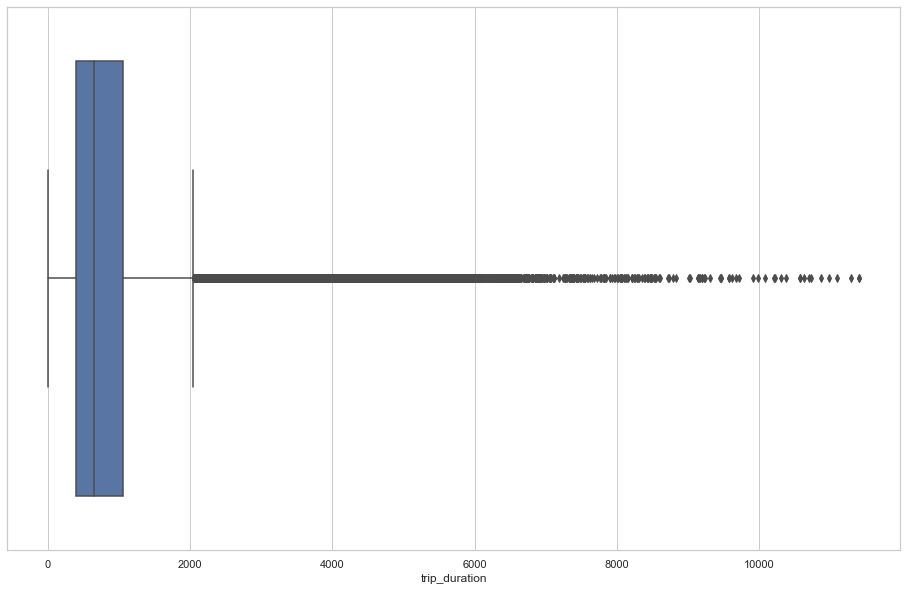

In [158]:
sns.set(style="whitegrid")
ax = sns.boxplot(train_data.trip_duration)

(array([3.2000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.6500e+02, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.8500e+02, 0.0000e+00, 0.0000e+00, 2.8200e+02,
        0.0000e+00, 0.0000e+00, 2.6300e+02, 0.0000e+00, 1.8300e+02,
        2.0200e+02, 0.0000e+00, 1.9100e+02, 2.2700e+02, 1.7400e+02,
        1.5700e+02, 1.4300e+02, 1.5600e+02, 3.0600e+02, 1.1700e+02,
        2.5500e+02, 1.3400e+02, 2.3200e+02, 2.2800e+02, 3.6500e+02,
        2.2400e+02, 3.5100e+02, 3.1800e+02, 4.2600e+02, 3.1800e+02,
        5.6100e+02, 5.3300e+02, 6.2100e+02, 7.6600e+02, 1.0500e+03,
        1.3490e+03, 1.6450e+03, 2.2060e+03, 3.0640e+03, 3.5390e+03,
        5.0610e+03, 5.8450e+03, 8.0520e+03, 1.0174e+04, 1.2702e+04,
        1.6315e+04, 1.8603e+04, 2.3094e+04, 2.7130e+04, 3.2019e+04,
        3.8015e+04, 4.1922e+04, 4.7421e+04, 5.3973e+04, 5.6655e+04,
        6.3311e+04, 6.5175e+04, 7.0770e+04, 7.1747e+04, 7.3317e+04,
        7.2638e+04, 7.2578e+04, 6.9958e+04, 6.91

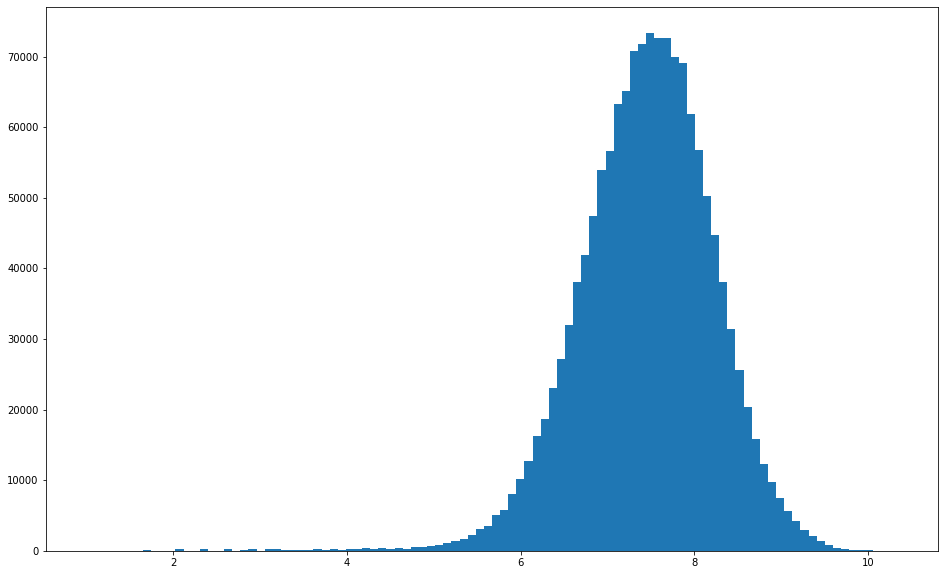

In [138]:
# apply log tranformation on the duration:
# applied function follows normal distribution
plt.hist(train_data.trip_duration.apply(np.log)+1, bins=100)


# Start to explore/construct features



construct the time features

In [139]:
# what can be additional features? time of the day, day of week, day of month, distance between A and B
train_data['day_of_month'] = train_data.pickup_datetime.dt.day
train_data['month'] = train_data.pickup_datetime.dt.month
train_data['hour_of_day'] = train_data.pickup_datetime.dt.hour
train_data['weekday'] = train_data.pickup_datetime.dt.weekday
#train_data.pickup_datetime.dt.year.nunique() # there is only one year worth of data


In [140]:
# see the range of the data, repeat the same exercise for testing dataset.
print(train_data['day_of_month'].nunique(), train_data['month'].nunique(), train_data['hour_of_day'].nunique(), train_data['weekday'].nunique())

31 6 24 7


construct the distance metric

In [141]:
# Now construct the distance, we use the haversine distance.
def haversine(lat1, lon1, lat2, lon2): 
      
    # distance between latitudes 
    # and longitudes 
    dLat = (lat2 - lat1) * pi / 180.0
    dLon = (lon2 - lon1) * pi / 180.0
  
    # convert to radians 
    lat1 = (lat1) * pi / 180.0
    lat2 = (lat2) * pi / 180.0
  
    # apply formulae 
    a = (pow(sin(dLat / 2), 2) + 
         pow(sin(dLon / 2), 2) * 
             cos(lat1) * cos(lat2)); 
    rad = 6371
    c = 2 * asin(sqrt(a)) 
    return rad * c 

In [41]:
train_data.loc[:,'haversine_dist'] = train_data.apply(lambda row: haversine(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis=1)

In [42]:
train_data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,day_of_month,month,hour_of_day,weekday,haversine_dist
count,1.439183e+06,1.439183e+06,1.439183e+06,1.439183e+06,1.439183e+06,1.439183e+06,1.439183e+06,1.439183e+06,1.439183e+06,1.439183e+06,1.439183e+06,1.439183e+06
mean,1.534944e+00,1.664765e+00,-7.397380e+01,4.075103e+01,-7.397356e+01,4.075165e+01,8.246200e+02,1.550240e+01,3.515885e+00,1.361597e+01,3.048878e+00,3.294360e+00
std,4.987776e-01,1.314836e+00,3.720630e-02,2.747058e-02,3.263890e-02,2.966826e-02,6.442495e+02,8.702230e+00,1.681077e+00,6.379662e+00,1.953604e+00,3.665256e+00
min,1.000000e+00,0.000000e+00,-7.402995e+01,4.063000e+01,-7.403000e+01,4.063000e+01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073747e+01,-7.399129e+01,4.073626e+01,3.940000e+02,8.000000e+00,2.000000e+00,9.000000e+00,1.000000e+00,1.224653e+00
50%,2.000000e+00,1.000000e+00,-7.398177e+01,4.075411e+01,-7.397986e+01,4.075451e+01,6.560000e+02,1.500000e+01,4.000000e+00,1.400000e+01,3.000000e+00,2.068513e+00
75%,2.000000e+00,2.000000e+00,-7.396751e+01,4.076832e+01,-7.396349e+01,4.076952e+01,1.056000e+03,2.300000e+01,5.000000e+00,1.900000e+01,5.000000e+00,3.768370e+00
max,2.000000e+00,6.000000e+00,-7.375066e+01,4.085000e+01,-7.375000e+01,4.085000e+01,1.141100e+04,3.100000e+01,6.000000e+00,2.300000e+01,6.000000e+00,2.719163e+01


In [43]:
def manhattan(lat1, lon1, lat2, lon2):
    d1 = haversine(lat1, lon1, lat1, lon2)
    d2 = haversine(lat1, lon2, lat2, lon2)
    total_dist = d1+d2
    return total_dist

In [44]:
train_data.loc[:,'manhattan_dist'] = train_data.apply(lambda row: manhattan(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis=1)

In [45]:
# train_data.describe()
train_data['trip_duration'].corr(train_data['haversine_dist'])

0.7686012340583777

In [59]:
X = train_data.haversine_dist.values.reshape(-1, 1) # numberical values
y = np.log(train_data.trip_duration.values.reshape(-1,1))+1 # log transform the y data.

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)
rmse = np.sqrt(mean_squared_error(y, y_pred))  
print('Linear regression Modeling RMSE %.5f' % rmse)




Linear regression Modeling RMSE 0.59108


In [60]:
train_data['trip_duration'].corr(train_data['manhattan_dist'])

0.7538864860803489

In [61]:
train_data['trip_duration'].corr(train_data['weekday'])

-0.035391880774398594

Text(0, 0.5, 'trip duration (sec)')

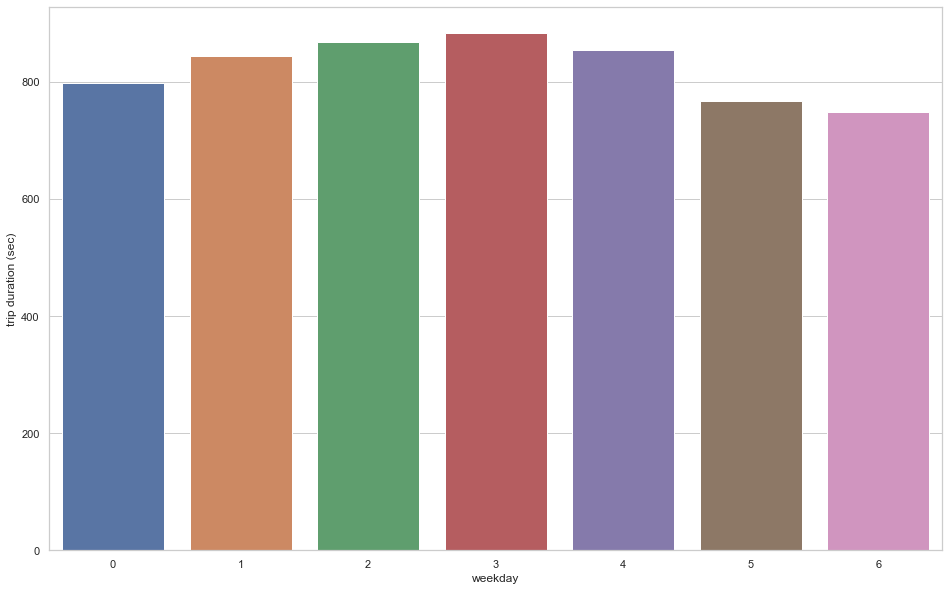

In [160]:
# Now let's visualize differernt day of the week effect
plt.figure()
weekday = train_data.groupby('weekday')['trip_duration'].mean()
sns.barplot(weekday.index, weekday.values)
plt.ylabel('trip duration (sec)')

# Wednesday is the most busy time

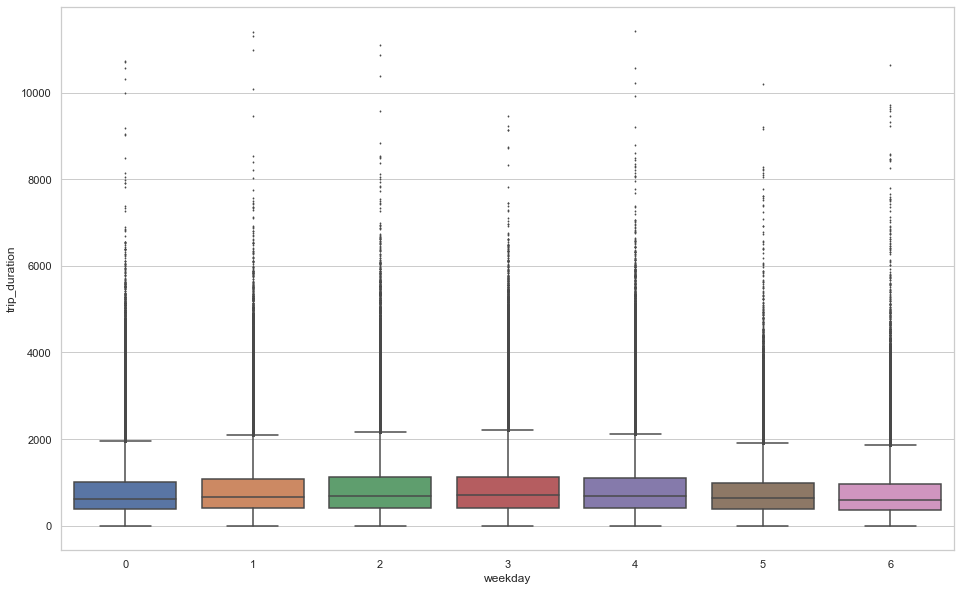

In [169]:

ax = sns.boxplot(x=train_data.weekday, y=train_data.trip_duration,fliersize=1)

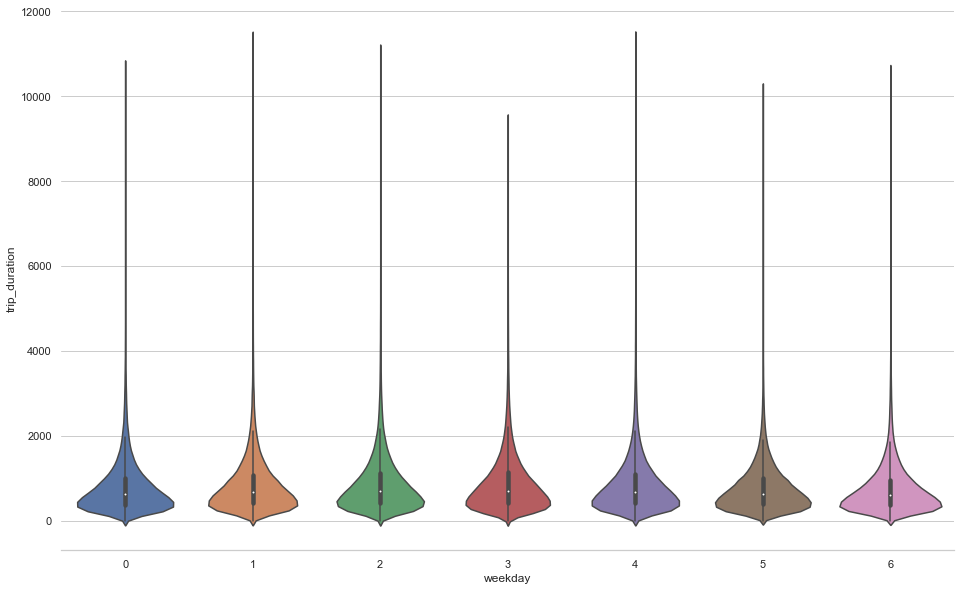

In [168]:
sns.violinplot(x=train_data.weekday, y=train_data.trip_duration)
sns.despine(left=True)

Text(0, 0.5, 'trip duration (sec)')

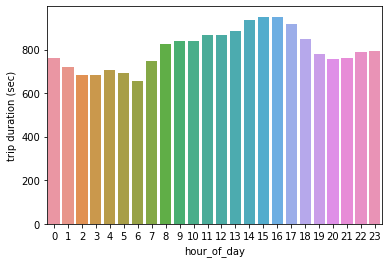

In [64]:
# visualize hour of the day effect
plt.figure()
hour = train_data.groupby('hour_of_day')['trip_duration'].mean()
sns.barplot(hour.index, hour.values)
plt.ylabel('trip duration (sec)')
# afternoon time is the most busy time

Text(0, 0.5, 'trip duration (sec)')

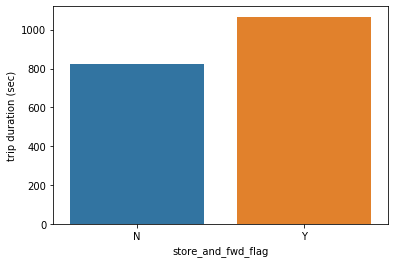

In [65]:
# visualize store_and_fwd_flag effect:
plt.figure()
flag = train_data.groupby('store_and_fwd_flag')['trip_duration'].mean()
sns.barplot(flag.index, flag.values)
plt.ylabel('trip duration (sec)')
# afternoon time is the most busy time

In [66]:
# get one hot encoding for the variables
vendor_train = pd.get_dummies(train_data['vendor_id'], prefix='vi', prefix_sep='_')
passenger_count_train = pd.get_dummies(train_data['passenger_count'], prefix='pc', prefix_sep='_')
store_and_fwd_flag_train = pd.get_dummies(train_data['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
month_train = pd.get_dummies(train_data['month'], prefix='m', prefix_sep='_')
day_of_month_train = pd.get_dummies(train_data['day_of_month'], prefix='dom', prefix_sep='_')
hour_train = pd.get_dummies(train_data['hour_of_day'], prefix='h', prefix_sep='_')
weekday_train = pd.get_dummies(train_data['weekday'], prefix='wd', prefix_sep='_')
vendor_train.shape

(1439183, 2)

In [67]:
vendor_train.index

Int64Index([      0,       1,       2,       3,       4,       5,       6,
                  7,       8,       9,
            ...
            1458634, 1458635, 1458636, 1458637, 1458638, 1458639, 1458640,
            1458641, 1458642, 1458643],
           dtype='int64', length=1439183)

In [68]:
# once this is constructed, we can save the file 
train_data.head()





,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,day_of_month,month,hour_of_day,weekday,haversine_dist,manhattan_dist
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,14,3,17,0,1.498521,1.735433
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,12,6,0,6,1.805507,2.430506
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,19,1,11,1,6.385098,8.203575
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,6,4,19,2,1.485498,1.661331
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,26,3,13,5,1.188588,1.199457


In [69]:
# one thing that is not being considered the notion of the neigbourhood
# the idea is to create cluster of neighbourhood base on proximity.


In [70]:
pd.concat([train_data, 
            vendor_train, 
            passenger_count_train,
            store_and_fwd_flag_train,
            month_train,
            day_of_month_train,
            hour_train,
            weekday_train], axis=1)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,h_21,h_22,h_23,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,0,0,0,1,0,0,0,0,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0,0,0,0,0,0,0,0,0,1
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,0,0,0,0,1,0,0,0,0,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,0,0,0,0,0,1,0,0,0,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,...,0,0,0,0,0,0,0,1,0,0
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,...,0,0,0,0,0,0,0,0,0,1
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,...,0,0,0,0,0,0,0,1,0,0
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,...,0,0,0,0,1,0,0,0,0,0


In [71]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 10, n_jobs = 4, random_state=21)
X = train_data.loc[:, ['pickup_longitude','pickup_latitude']]
km.fit(X)
labels = km.labels_
labels0 = km.predict(X)

In [72]:
labels0

array([9, 7, 3, ..., 8, 0, 9], dtype=int32)

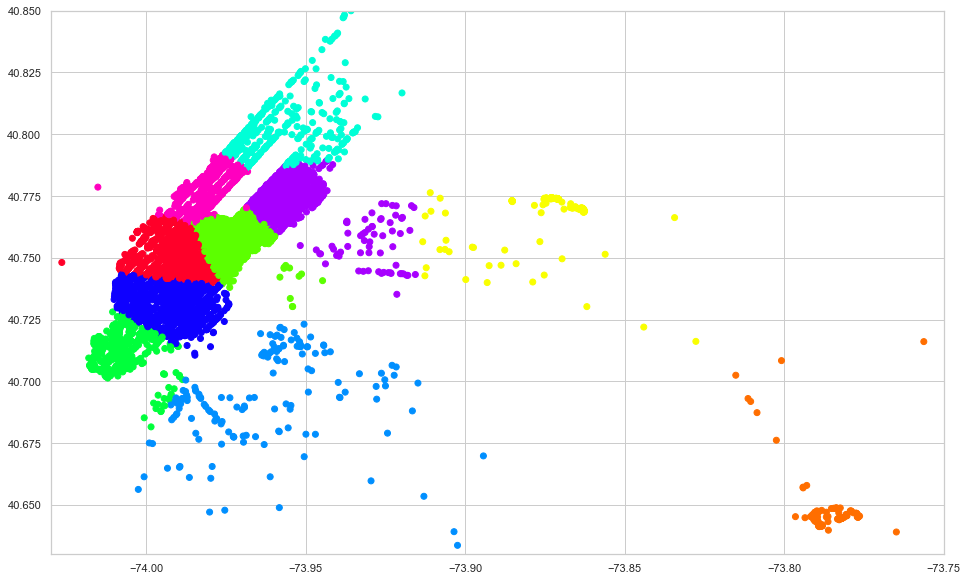

In [176]:

plt.figure()
plt.scatter(X.pickup_longitude[:10000], X.pickup_latitude[:10000],c=labels0[:10000], cmap='gist_rainbow')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()


In [74]:
# the kmean method itself is very slow, consider minibatch kmeans
# here are two tricks: 1. use minibatch kmeans, 
#.                     2. use a randomly choose subset of data to make the cluster, 
                        # here we used 1/4 of the data


coords = np.vstack((train_data[['pickup_latitude', 'pickup_longitude']].values,
                    train_data[['dropoff_latitude', 'dropoff_longitude']].values))
len(coords)

2878366

In [75]:
sample_ind = np.random.permutation(len(coords))[:500000]


In [76]:
sample_ind

array([ 269952,  372676, 1573970, ..., 2538901, 2192300, 2573974])

In [77]:
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [81]:
# Now the challenge is about how to find the optimal number of clusters.
# we can use the elbow method
Sum_of_squared_distances = []
K = range(50,280,20)
for k in K:
    km = MiniBatchKMeans(n_clusters=k, batch_size=10000).fit(coords[sample_ind])
    km = km.fit(coords[sample_ind])
    Sum_of_squared_distances.append(km.inertia_)

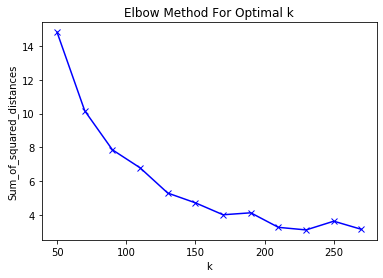

In [82]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [83]:
# I will choose n = 50 in this case
km_final = MiniBatchKMeans(n_clusters=50, batch_size=10000).fit(coords[sample_ind])
labels = km_final.labels_
clusters_pickup = km_final.predict(train_data.loc[:,['pickup_latitude','pickup_longitude']])
clusters_dropoff = km_final.predict(train_data.loc[:,['dropoff_latitude','dropoff_longitude']])


In [84]:
train_data.loc[:,['pickup_longitude','pickup_latitude']].values

array([[-73.98215485,  40.76793671],
       [-73.98041534,  40.73856354],
       [-73.97902679,  40.7639389 ],
       ...,
       [-73.95912933,  40.76879883],
       [-73.98207855,  40.74906158],
       [-73.97953796,  40.78174973]])

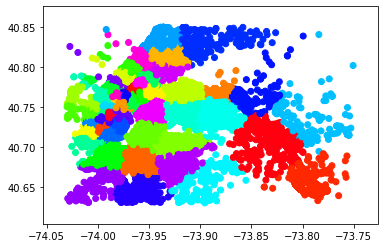

In [85]:
plt.figure()
plt.scatter(X.pickup_longitude, X.pickup_latitude,c=clusters_pickup, cmap='gist_rainbow')
plt.show()

In [86]:
# next step is to generate the one hot encoding for pickup and droppoff neighbourhood
pickup_neighbour = pd.get_dummies(clusters_pickup, prefix='pickN', prefix_sep='_')
dropoff_neighbour = pd.get_dummies(clusters_dropoff, prefix='dropN', prefix_sep='_')



In [87]:
clusters_pickup

array([49, 41, 49, ..., 19,  7, 42], dtype=int32)

In [88]:
dropoff_neighbour

,dropN_0,dropN_1,dropN_2,dropN_3,dropN_4,dropN_5,dropN_6,dropN_7,dropN_8,dropN_9,...,dropN_40,dropN_41,dropN_42,dropN_43,dropN_44,dropN_45,dropN_46,dropN_47,dropN_48,dropN_49
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439178,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1439179,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1439180,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1439181,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
dropoff_neighbour.index

RangeIndex(start=0, stop=1439183, step=1)

In [90]:
len(train_data),len(vendor_train),len(passenger_count_train),len(store_and_fwd_flag_train), len(month_train),len(day_of_month_train),len(hour_train),len(weekday_train),len(pickup_neighbour),len(dropoff_neighbour) 

(1439183,
 1439183,
 1439183,
 1439183,
 1439183,
 1439183,
 1439183,
 1439183,
 1439183,
 1439183)

In [91]:
train_df_new = pd.concat([train_data, 
               vendor_train, 
               passenger_count_train,
               store_and_fwd_flag_train,
               month_train,
               day_of_month_train,
               hour_train,
               weekday_train], axis=1)

In [92]:
train_df_new = train_df_new.reset_index(drop=True)
train_data.index


Int64Index([      0,       1,       2,       3,       4,       5,       6,
                  7,       8,       9,
            ...
            1458634, 1458635, 1458636, 1458637, 1458638, 1458639, 1458640,
            1458641, 1458642, 1458643],
           dtype='int64', length=1439183)

In [93]:
train_df_new = pd.concat([train_df_new, pickup_neighbour,dropoff_neighbour], axis=1)

In [94]:
pickup_neighbour.index

RangeIndex(start=0, stop=1439183, step=1)

In [95]:
train_df_new.index

RangeIndex(start=0, stop=1439183, step=1)

In [96]:
# then we need to split the train test to 80, 20 and use the xgboost
train_df_new.to_csv('train_processed.csv')

In [97]:
train_df_new.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,day_of_month,month,hour_of_day,...,dropN_40,dropN_41,dropN_42,dropN_43,dropN_44,dropN_45,dropN_46,dropN_47,dropN_48,dropN_49
count,1.439183e+06,1.439183e+06,1.439183e+06,1.439183e+06,1.439183e+06,1.439183e+06,1.439183e+06,1.439183e+06,1.439183e+06,1.439183e+06,...,1.439183e+06,1.439183e+06,1.439183e+06,1.439183e+06,1.439183e+06,1.439183e+06,1.439183e+06,1.439183e+06,1.439183e+06,1.439183e+06
mean,1.534944e+00,1.664765e+00,-7.397380e+01,4.075103e+01,-7.397356e+01,4.075165e+01,8.246200e+02,1.550240e+01,3.515885e+00,1.361597e+01,...,2.772962e-02,3.318897e-02,2.428322e-02,4.124562e-03,2.823824e-03,9.262894e-03,5.857490e-03,2.950354e-02,1.324849e-02,3.320009e-02
std,4.987776e-01,1.314836e+00,3.720630e-02,2.747058e-02,3.263890e-02,2.966826e-02,6.442495e+02,8.702230e+00,1.681077e+00,6.379662e+00,...,1.641972e-01,1.791298e-01,1.539271e-01,6.409020e-02,5.306461e-02,9.579718e-02,7.630979e-02,1.692132e-01,1.143371e-01,1.791588e-01
min,1.000000e+00,0.000000e+00,-7.402995e+01,4.063000e+01,-7.403000e+01,4.063000e+01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073747e+01,-7.399129e+01,4.073626e+01,3.940000e+02,8.000000e+00,2.000000e+00,9.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.000000e+00,1.000000e+00,-7.398177e+01,4.075411e+01,-7.397986e+01,4.075451e+01,6.560000e+02,1.500000e+01,4.000000e+00,1.400000e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.000000e+00,2.000000e+00,-7.396751e+01,4.076832e+01,-7.396349e+01,4.076952e+01,1.056000e+03,2.300000e+01,5.000000e+00,1.900000e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.000000e+00,6.000000e+00,-7.375066e+01,4.085000e+01,-7.375000e+01,4.085000e+01,1.141100e+04,3.100000e+01,6.000000e+00,2.300000e+01,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [98]:
train_df_new.info

<bound method DataFrame.info of                 id  vendor_id     pickup_datetime    dropoff_datetime  \
0        id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   
1        id2377394          1 2016-06-12 00:43:35 2016-06-12 00:54:38   
2        id3858529          2 2016-01-19 11:35:24 2016-01-19 12:10:48   
3        id3504673          2 2016-04-06 19:32:31 2016-04-06 19:39:40   
4        id2181028          2 2016-03-26 13:30:55 2016-03-26 13:38:10   
...            ...        ...                 ...                 ...   
1439178  id2376096          2 2016-04-08 13:31:04 2016-04-08 13:44:02   
1439179  id1049543          1 2016-01-10 07:35:15 2016-01-10 07:46:10   
1439180  id2304944          2 2016-04-22 06:57:41 2016-04-22 07:10:25   
1439181  id2714485          1 2016-01-05 15:56:26 2016-01-05 16:02:39   
1439182  id1209952          1 2016-04-05 14:44:25 2016-04-05 14:47:43   

         passenger_count  pickup_longitude  pickup_latitude  \
0                      1    

In [99]:
train_df_new.dropN_46

0          0
1          0
2          0
3          0
4          0
          ..
1439178    0
1439179    0
1439180    0
1439181    0
1439182    0
Name: dropN_46, Length: 1439183, dtype: uint8

In [100]:
clusters_dropoff

array([19, 33, 25, ..., 25, 38, 12], dtype=int32)

In [106]:
len(dropoff_neighbour)

1439183

In [107]:
train_data

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,day_of_month,month,hour_of_day,weekday,haversine_dist,manhattan_dist
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,14,3,17,0,1.498521,1.735433
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,12,6,0,6,1.805507,2.430506
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,19,1,11,1,6.385098,8.203575
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,6,4,19,2,1.485498,1.661331
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,26,3,13,5,1.188588,1.199457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016-04-08,8,4,13,4,1.225080,1.665895
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016-01-10,10,1,7,6,6.049836,8.058580
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016-04-22,22,4,6,4,7.824606,10.645646
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016-01-05,5,1,15,1,1.092564,1.521850


In [108]:
train_df_new0 = pd.concat([train_data, 
               vendor_train, 
               passenger_count_train,
               store_and_fwd_flag_train,
               month_train,
               day_of_month_train,
               hour_train,
               weekday_train], axis=1)

In [109]:
train_df_new0=train_df_new0.reset_index().drop('index',axis = 1)

train_df_new0

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,h_21,h_22,h_23,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,0,0,0,1,0,0,0,0,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0,0,0,0,0,0,0,0,0,1
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,0,0,0,0,1,0,0,0,0,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,0,0,0,0,0,1,0,0,0,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439178,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,...,0,0,0,0,0,0,0,1,0,0
1439179,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,...,0,0,0,0,0,0,0,0,0,1
1439180,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,...,0,0,0,0,0,0,0,1,0,0
1439181,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,...,0,0,0,0,1,0,0,0,0,0


In [110]:
train_df_new0.loc[:, 'pickup_cluster'] = clusters_pickup
train_df_new0.loc[:, 'dropoff_cluster'] = clusters_dropoff

In [111]:
train_df_new0

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,h_23,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,pickup_cluster,dropoff_cluster
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,0,1,0,0,0,0,0,0,49,19
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0,0,0,0,0,0,0,1,41,33
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,0,0,1,0,0,0,0,0,49,25
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,0,0,0,1,0,0,0,0,11,25
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,0,0,0,0,0,0,1,0,12,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439178,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,...,0,0,0,0,0,1,0,0,41,24
1439179,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,...,0,0,0,0,0,0,0,1,14,18
1439180,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,...,0,0,0,0,0,1,0,0,19,25
1439181,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,...,0,0,1,0,0,0,0,0,7,38


In [112]:
train_df_new0.to_csv('train_processed_cluster_in_number.csv')